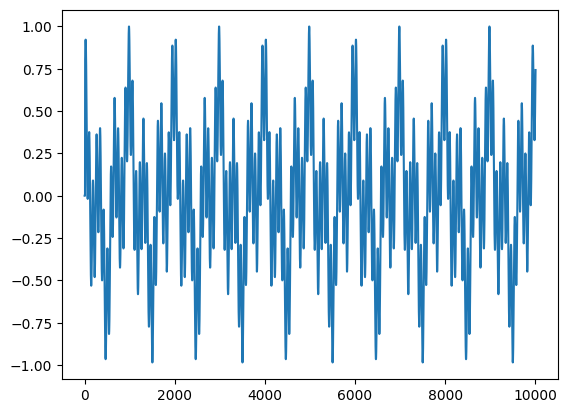

In [2]:
import math
import numpy as np
import mindspore
import mindspore.nn as nn
from mindspore import mint
from mindspore import Tensor
from mindspore import Parameter
import mindspore.ops as ops
from mindspore import dtype as mstype
from mindspore.common.initializer import initializer, XavierUniform
import matplotlib.pyplot as plt

mindspore.set_context(device_target='CPU')

def calculate_gain(nonlinearity, param=None):
    if nonlinearity == 'linear':
        return 1.0
    elif nonlinearity == 'relu':
        return math.sqrt(2.0)
    elif nonlinearity == 'tanh':
        return 5 / 3
    else:
        raise ValueError(f"Unsupported nonlinearity: {nonlinearity}")

class Conv(nn.Cell):
    """
    A convolution layer with the option to be causal and use uniform initialization.
    """
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 dilation=1, bias=True, w_init_gain='linear', is_causal=False):
        super(Conv, self).__init__()
        self.is_causal = is_causal
        self.kernel_size = kernel_size
        self.dilation = dilation

        self.conv = nn.Conv1d(in_channels, out_channels,
                              kernel_size=kernel_size, stride=stride,
                              dilation=dilation, has_bias=bias, pad_mode='valid')

        self.conv.weight = Parameter(initializer(XavierUniform(gain=calculate_gain(w_init_gain)), self.conv.weight.shape, mindspore.float32))

    def construct(self, signal):
        if self.is_causal:
            padding = (self.kernel_size - 1) * self.dilation
            # Pad only along the time dimension (last dimension)
            signal = ops.Pad(((0, 0), (0, 0), (padding, 0)))(signal)
        return self.conv(signal)

class WaveNetEncoder(nn.Cell):
    def __init__(self, n_layers, max_dilation, n_residual_channels, n_dilated_channels, encoding_factor, encoding_stride=1):
        super(WaveNetEncoder, self).__init__()

        self.n_layers = n_layers
        self.max_dilation = max_dilation
        self.n_residual_channels = n_residual_channels
        self.encoding_factor = encoding_factor
        self.encoding_stride = encoding_stride
        self.n_dilated_channels = n_dilated_channels

        self.dilate_layers = nn.CellList()
        self.res_layers = nn.CellList()

        # Initial convolution layer
        self.NCInput = Conv(1, self.n_residual_channels)

        # Define the layers in the residual network
        loop_factor = math.floor(math.log2(max_dilation)) + 1
        for i in range(self.n_layers):
            # Double dilation up to max dilation.
            dilation = 2 ** (i % loop_factor)

            # Build Dilation layer
            d_layer = Conv(self.n_residual_channels, self.n_dilated_channels, kernel_size=2, dilation=dilation, w_init_gain='tanh')
            self.dilate_layers.append(d_layer)

            # Build Res layer
            res_layer = Conv(self.n_dilated_channels, self.n_residual_channels, w_init_gain='linear')
            self.res_layers.append(res_layer)

        # Final layer
        self.final_layer = Conv(self.n_residual_channels, 1)

        # Pooling layer
        self.pooling_layer = nn.AvgPool1d(self.encoding_factor, stride=encoding_stride)

    def construct(self, signal):
        # NC Conv
        signal = self.NCInput(signal)

        for i in range(self.n_layers):
            # Save this for now.
            skip = signal

            # Run block.
            signal = ops.ReLU()(signal)
            signal = self.dilate_layers[i](signal)
            signal = ops.ReLU()(signal)
            signal = self.res_layers[i](signal)

            # Dilate layers can clip this, so resize.
            length = signal.shape[2]
            skip = skip[:, :, -length:]

            signal = signal + skip

        # Run the last 1x1 layer
        signal = self.final_layer(signal)

        # Pooling for encoding.
        signal = self.pooling_layer(signal)

        return signal


# Generate fake data
numTSteps = 10000
zeropad = 9
length = 10
dt = length / numTSteps
times = np.array([dt for i in range(numTSteps)])
times = np.cumsum(times)

signal = np.zeros(numTSteps + zeropad)
signal[zeropad:] = (np.cos(2 * math.pi * times + math.pi / 10) +
                    np.cos(6 * math.pi * times + math.pi / 10) +
                    np.sin(25 * math.pi * times + math.pi / 10))
signal = signal / (np.max(signal) + 0.001)
signalt = Tensor(signal, mstype.float32).expand_dims(0).expand_dims(0)

plt.plot(signal)

In [3]:
encoder = WaveNetEncoder(n_layers=10,max_dilation=128,n_residual_channels=3,n_dilated_channels=6, encoding_factor=500, encoding_stride=500)

In [4]:
#Test individual layers.
signal = encoder.NCInput(signalt)
signal.shape

(1, 3, 10009)

In [5]:
skip = signal
signal = mint.nn.functional.relu(signal)
signal = encoder.dilate_layers[0](signal)
print(signal.shape)

(1, 6, 10008)


In [6]:
signal = mint.nn.functional.relu(signal)
signal = encoder.res_layers[0](signal)
length = signal.shape[2]
print(signal.shape)

(1, 3, 10008)


In [7]:
skip.shape

(1, 3, 10009)

In [8]:
skip = skip[:,:,-length:]

In [9]:
skip.shape

(1, 3, 10008)

In [14]:
signal = signal + skip
signal.shape

(1, 3, 10008)

In [15]:
signal = encoder.final_layer(signal)
signal.shape

(1, 1, 10008)

In [16]:
signal = encoder.pooling_layer(signal)
signal.shape

(1, 1, 20)

In [17]:
encoding = encoder(signalt)
encoding.shape

(1, 1, 19)